### Training of modified U-Net for Optic Disc on RIM-ONE v3 database (cross-validation fold #0).

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt

from model_rimone import *
from process_images_rimone import *
from process_result import *

print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.5.0
TensorFlow version: 2.5.0


In [2]:
suf = '_gap_70'
epochs = NUM_EPOCHS
spe = SPE
img_size = IMG_SIZE
arq_name = 'rim_one_rgb_green'
lr_cup = 7e-4
prefix_results = 'rgb_green'

arch_name_cup = "Cup, log_dice loss"
arch_name_disc = "Disc, log_dice loss"

In [3]:
images, cups, discs = get_images(suf)
images = get_color_channel(1, images)
labels = np.array(h5f['RIM-ONE v3/512 px/is_ill'])

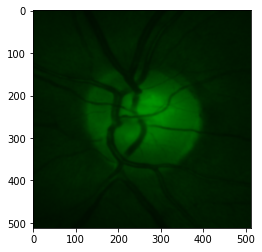

In [4]:
plt.imshow(images[0])

In [ ]:
num_splits = 5
train_idx_cv, test_idx_cv = [], []
for _train_idx, _test_idx in KFold(n_splits=num_splits, random_state=1, shuffle=True).split(images):
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)
    
train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]
print(len(train_idx))
print(len(test_idx))

In [ ]:
for k in range(num_splits):
    folder_name = root_path_kfold(arq_name, k)
    
    train_idx = train_idx_cv[k]
    test_idx = test_idx_cv[k]
    
    print('------------- training cup --------------')
    
    X_valid, Y_valid = next(data_generator(images, cups, train_idx, test_idx, train_or_test = 'test', batch_size=100, stationary=True))
    model = create_compile_model(img_size, lr_cup)
    weights_folder = os.path.join(folder_name, 'models_weights', '{},{}'.format(datetime.now().strftime('%d.%m,%H-%M'), arch_name_cup))
    
    history_cup = train_cup(images, cups, 'cup_' + prefix_results + '_rimone', 
                         model, epochs, X_valid, Y_valid, img_size, spe, train_idx, test_idx, weights_folder)
    
    pred_iou, pred_dice, pred_cup = predict(images, X_valid, Y_valid, model, img_size, test_idx)
    save_iou_dice(np.mean(pred_iou), np.mean(pred_dice), folder_name, prefix_results + '_mean_iou_dice_cup.csv')
    save_predict_images(folder_name, 'cups', test_idx, pred_cup)
        
    print('------------- training disc --------------')
    
    X_valid, Z_valid = next(data_generator(images, discs, train_idx, test_idx, train_or_test='test', batch_size=100, stationary=True))
    model_disc = create_compile_model(img_size, 1e-3)
    weights_folder = os.path.join(folder_name, 'models_weights', '{},{}'.format(datetime.now().strftime('%d.%m,%H-%M'), arch_name_disc))
    
    history_disc = train_disc(images, discs, 'disc_' + prefix_results + '_rimone', 
                         model_disc, epochs, X_valid, Z_valid, img_size, spe, train_idx, test_idx, weights_folder)
    
    pred_iou, pred_dice, pred_disc = predict(images, X_valid, Z_valid, model_disc, img_size, test_idx)
    save_iou_dice(np.mean(pred_iou), np.mean(pred_dice), folder_name, prefix_results + '_mean_iou_dice_disc.csv')
    save_predict_images(folder_name, 'discs', test_idx, pred_disc)
    
    print('------------- results --------------')
    
    plot_results(history_cup, epochs, folder_name, arq_name + '_cup')
    plot_results(history_disc, epochs, folder_name, arq_name + '_disc')
    df, diametros = create_table_result_rimone(pred_cup, pred_disc, test_idx, folder_name, prefix_results, labels) 
    